1. Data Preparation & Text Cleaning

We load the CSV file containing the song lyrics and clean the text by lowercasing, removing punctuation, tokenizing, and eliminating common English stop words.

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import pandas as pd
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    tokens = text.split()
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]
    return " ".join(tokens)

# Load the dataset and apply the cleaning function
df = pd.read_csv('../spotify_tracks_50_with_lyrics.csv')
df['cleaned_lyrics'] = df['lyrics'].apply(clean_text)
df.head()


,track_uri,album_name,album_uri,artist_name,artist_uri,duration_ms,pos,track_name,inside_playlists,lyrics,cleaned_lyrics
0,spotify:track:4pLwZjInHj3SimIyN9SnOz,Dangerous Woman,spotify:album:4lVR2fg3DAUQpGVJ6DciHW,Ariana Grande,spotify:artist:66CXWjxzNUsdJxJ2JdwvnR,226160,0,Side To Side,[584466 290613 339107 ... 932309 757216 867665],I've been here all night (Ariana)\nI've been h...,ive night ariana ive day nicki minaj boy got w...
1,spotify:track:37f4ITSlgPX81ad2EvmVQr,Wildfire,spotify:album:0mFDIOqypzHp6Xd0el1hoT,Rachel Platten,spotify:artist:3QLIkT4rD2FMusaqmkepbq,204013,1,Fight Song,[584466 290613 540271 ... 535890 217688 26462],Like a small boat on the ocean\nSending big wa...,like small boat ocean sending big waves motion...
2,spotify:track:6i0V12jOa3mr6uu4WYhUBr,Heathens,spotify:album:3J8W9AOjQhnBLCX33m3atT,Twenty One Pilots,spotify:artist:3YQKmKGau1PzlVlkL1iodx,195920,2,Heathens,[584466 290613 339107 ... 349806 168239 932309],"All my friends are heathens, take it slow (In ...",friends heathens slow city boy city wait ask k...
3,spotify:track:2DpCdPMg1BADE4HDnxt3Rd,"Sit Still, Look Pretty",spotify:album:2cE2eOy7alOZHpuelJEV8Q,Daya,spotify:artist:6Dd3NScHWwnW6obMFbl1BH,202226,3,"Sit Still, Look Pretty",[584466 414677 809633 ... 6555 349244 395752],"Could dress up to get love, but guess what?\nI...",dress love guess im gonna girl whos living bar...
4,spotify:track:6Knv6wdA0luoMUuuoYi2i1,MY HOUSE,spotify:album:5lkNnHVlnCCCV304t89wOH,Flo Rida,spotify:artist:0jnsk9HBra6NMjO2oANoPY,192190,4,My House,[584466 290613 968716 ... 257996 349976 6463],"Open up the champagne, pop\nIt's my house, com...",open champagne pop house come turn uh hear kno...


2. Preliminary Analysis: Word Cloud

We create a word cloud to visualize the most frequent words in our cleaned lyrics, giving a quick insight into recurring themes.

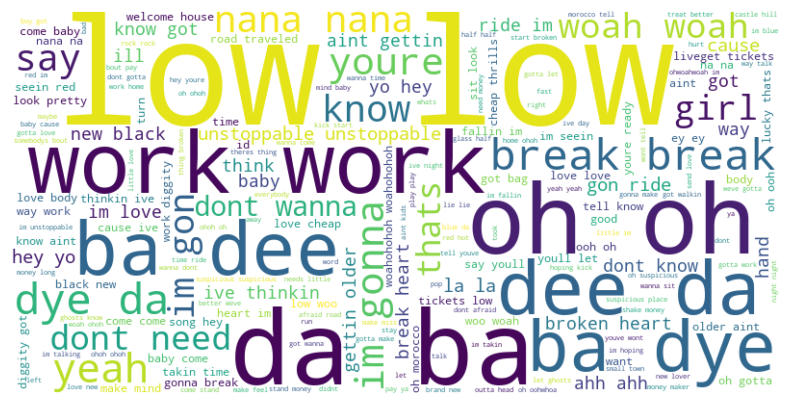

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = " ".join(df['cleaned_lyrics'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


3. Sentiment Analysis Using a Pre-trained BERT Model

a. Setup the Sentiment Pipeline

We initialize the Hugging Face sentiment analysis pipeline and load a tokenizer for handling long texts.

In [23]:
from transformers import pipeline, AutoTokenizer

sentiment_pipeline = pipeline("sentiment-analysis")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


b. Splitting Long Texts into Chunks

Since many transformer models have a token limit (e.g., 512 tokens), we split long texts into manageable chunks.

In [24]:
def split_text_by_tokens(text, max_tokens=512):
    """
    Splits a text into chunks where each chunk has at most max_tokens tokens.
    """
    tokens = tokenizer.tokenize(text)
    chunks = []
    for i in range(0, len(tokens), max_tokens):
        chunk_tokens = tokens[i:i+max_tokens]
        chunk_text = tokenizer.convert_tokens_to_string(chunk_tokens)
        chunks.append(chunk_text)
    return chunks


c. Aggregating Sentiment Scores Across Chunks

We process each chunk, accumulate positive and negative scores, and determine the overall sentiment.

In [25]:
def get_sentiment_full_text(text, threshold=0.1):
    """
    Splits the text into chunks and gets sentiment for each chunk.
    Aggregates the sentiment scores to decide an overall sentiment.
    """
    chunks = split_text_by_tokens(text)
    
    pos_score = 0.0
    neg_score = 0.0
    
    for chunk in chunks:
        result = sentiment_pipeline(chunk, truncation=True)[0]
        if result['label'] == 'POSITIVE':
            pos_score += result['score']
        elif result['label'] == 'NEGATIVE':
            neg_score += result['score']
    
    if pos_score > neg_score * (1 + threshold):
        return 'Positive'
    elif neg_score > pos_score * (1 + threshold):
        return 'Negative'
    else:
        return 'Neutral'


d. Applying Sentiment Analysis and Visualizing the Results

Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors


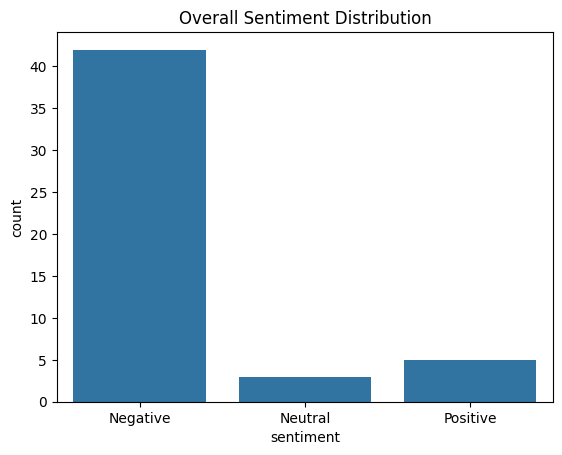

In [26]:
df['sentiment'] = df['cleaned_lyrics'].apply(get_sentiment_full_text)

import seaborn as sns

sns.countplot(x='sentiment', data=df)
plt.title("Overall Sentiment Distribution")
plt.show()


4. Emotion Analysis

We use an emotion-specific model to extract emotions (e.g., Joy, Anger, Sadness) from the lyrics. If the text exceeds the model’s token limit, we split it into chunks and take the most common emotion as the overall result.

a. Setup the Emotion Pipeline

In [27]:
from transformers import pipeline, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/bert-base-uncased-emotion")
max_length = tokenizer.model_max_length  # typically 512

emotion_pipeline = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion")


Device set to use mps:0


b. Define the Emotion Extraction Function

In [28]:
def get_emotion(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, truncation=False)
    if len(tokens) > max_length:
        emotions = []
        for i in range(0, len(tokens), max_length):
            chunk_tokens = tokens[i:i+max_length]
            chunk_text = tokenizer.decode(chunk_tokens, skip_special_tokens=True)
            result = emotion_pipeline(chunk_text, truncation=True)
            chunk_emotion = max(result, key=lambda x: x['score'])['label']
            emotions.append(chunk_emotion)
        return max(set(emotions), key=emotions.count)
    else:
        result = emotion_pipeline(text, truncation=True)
        return max(result, key=lambda x: x['score'])['label']


c. Apply Emotion Analysis and Visualize the Results

Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors


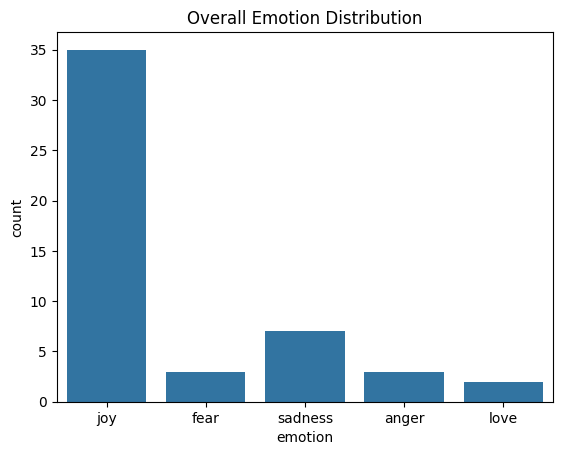

In [29]:
df['emotion'] = df['cleaned_lyrics'].apply(get_emotion)

sns.countplot(x='emotion', data=df)
plt.title("Overall Emotion Distribution")
plt.show()


5. Topic Modeling with LDA

We apply TF-IDF vectorization followed by Latent Dirichlet Allocation (LDA) to extract topics from the lyrics.

Each topic is represented by a set of words that frequently appear together

a. TF-IDF Vectorization

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf = vectorizer.fit_transform(df['cleaned_lyrics'])


b. Latent Dirichlet Allocation

In [31]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=42)
topics = lda.fit_transform(tfidf)

c. Display the Top Words for Each Topic

In [32]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)


Topic 0:
low come ive way got im hey yo house da
Topic 1:
oh dont suspicious youre believe older domino know wanna hey
Topic 2:
ahh unstoppable tell half woahohohoh red im oh morocco thats
Topic 3:
la gon im ey love wanted somebody small money little
Topic 4:
oh break gotta work woah im new nana love black


In [33]:
# Sum the topic weights for each topic across all documents
total_weights = topics.sum(axis=0)

# Normalize to get the proportion of each topic relative to the total sum of weights
topic_proportions = total_weights / total_weights.sum()

# Print the topic proportions
for i, proportion in enumerate(topic_proportions):
    print(f"Topic {i}: {proportion:.2%}")


Topic 0: 21.70%
Topic 1: 17.03%
Topic 2: 18.28%
Topic 3: 15.40%
Topic 4: 27.59%


6. Song Similarity Using Sentence Embeddings

We generate embeddings for each song’s lyrics using a Sentence Transformer and compute cosine similarity between the embeddings.

a. Generating Embeddings

In [34]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['cleaned_lyrics'].tolist(), convert_to_tensor=True)


b. Computing Cosine Similarity

In [35]:
# Compute cosine similarity between all pairs of songs
cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)

# Example: Similarity between the first and second song
print(cosine_scores)


tensor([[1.0000, 0.5201, 0.4867,  ..., 0.5958, 0.5406, 0.5822],
        [0.5201, 1.0000, 0.4889,  ..., 0.5728, 0.5337, 0.4649],
        [0.4867, 0.4889, 1.0000,  ..., 0.4875, 0.3988, 0.4291],
        ...,
        [0.5958, 0.5728, 0.4875,  ..., 1.0000, 0.4949, 0.6304],
        [0.5406, 0.5337, 0.3988,  ..., 0.4949, 1.0000, 0.4866],
        [0.5822, 0.4649, 0.4291,  ..., 0.6304, 0.4866, 1.0000]],
       device='mps:0')


In [36]:
import torch

# Compute cosine similarity matrix
cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)

# Move to CPU and convert to numpy
cosine_matrix = cosine_scores.cpu().numpy()

# Get the indices of the upper triangular part of the matrix (excluding diagonal)
num_songs = cosine_matrix.shape[0]
similarity_pairs = []

for i in range(num_songs):
    for j in range(i + 1, num_songs):  # Avoid diagonal and duplicates
        similarity_pairs.append((i, j, cosine_matrix[i, j]))

# Sort by similarity score in descending order
sorted_pairs = sorted(similarity_pairs, key=lambda x: x[2], reverse=False)

# Select top 10 highest similarity scores
top_10_similar = sorted_pairs[:10]

# Display results
print("Top 10 Most Similar Song Pairs:")
for idx, (song1, song2, score) in enumerate(top_10_similar):
    print(f"{idx+1}. Song {song1} ↔ Song {song2}: Similarity Score = {score:.4f}")

# Extract the first (most similar) song pair
most_similar_song1, most_similar_song2, highest_score = top_10_similar[0]

# Extract their lyrics from DataFrame (assuming df['lyrics'] contains lyrics)
lyrics1 = df.iloc[most_similar_song1]['lyrics']
lyrics2 = df.iloc[most_similar_song2]['lyrics']

# Display the lyrics for both songs
print(f"\nMost Similar Songs (Score: {highest_score:.4f}):")
print(f"Song 1 (Index {most_similar_song1}):\n{lyrics1}\n")
print(f"Song 2 (Index {most_similar_song2}):\n{lyrics2}")


Top 10 Most Similar Song Pairs:
1. Song 25 ↔ Song 28: Similarity Score = 0.2744
2. Song 15 ↔ Song 48: Similarity Score = 0.2794
3. Song 6 ↔ Song 25: Similarity Score = 0.2795
4. Song 15 ↔ Song 28: Similarity Score = 0.2949
5. Song 8 ↔ Song 42: Similarity Score = 0.2963
6. Song 17 ↔ Song 28: Similarity Score = 0.2995
7. Song 6 ↔ Song 48: Similarity Score = 0.3111
8. Song 25 ↔ Song 42: Similarity Score = 0.3147
9. Song 15 ↔ Song 33: Similarity Score = 0.3249
10. Song 18 ↔ Song 25: Similarity Score = 0.3274

Most Similar Songs (Score: 0.2744):
Song 1 (Index 25):
I've seen it all, all before
And now I want something more
And what is that? And what is that?
It's the new black
What you want, me to do
Now you got, someone new
It's not enough, oh to get your thrill
You took it all, for one more kill
And what is that? And what is that?
It's the new black, It's the new black
It's the new black, It's the new black
It's the new black
I've seen it all, all before
And now I want something more
So wh